## **Paquetes**

In [1]:
%%capture
# Paquete de Python que facilita la manipulación de datos terrestres
!pip install earthpy

# Librería Basemap
#!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1" "basemap-data-hires == 1.3.0b1"

# Raster managing package installing
!pip install rioxarray

# Basemap tiles package
!pip3 install contextily

# Auxiliary functions for geopandas
!pip install rtree

# Artist for matplotlib to display a scale bar
!pip install matplotlib-scalebar

In [2]:
%%capture
# Para que las gráficas tengan la fuente parecida a la de LaTeX
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

In [3]:
# Se importan funciones auxiliares desde GitHub para la cuantificación de datos
# faltantes
!git clone https://github.com/jsblandon/weather_data_uy_preprocessing.git
import sys
sys.path.append('/content/weather_data_uy_preprocessing')

Cloning into 'weather_data_uy_preprocessing'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 4.80 KiB | 4.80 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
import contextily as cx            # basemap tiles
import glob                        # files managing
import geopandas as gpd            # shapefile managing
import math                        # math operations
import matplotlib.colors as colors # customize colors
import matplotlib.pyplot as plt    # plots
import numpy as np                 # array managing
import os                          # directory managing
import pandas as pd                # structured data managing
import rioxarray as rxr            # raster managing
import seaborn as sns              # plots
import matplotlib.image as mpimg   # to add compass to maps
from geopandas import GeoDataFrame # to create GeoPandas DataFrames
from glob import glob              # files managing
from matplotlib import rc          # LaTeX-based commands
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import to_rgba # color conversion
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar positioning
from pandas import DataFrame       # pandas dataframe structure
from shapely.geometry import mapping, Point, Polygon # for clipping rasters using shapes and geometries managing
from tqdm import tqdm              # Progress tracking
from warnings import simplefilter  # get rid off warnings
from weather_data_preprocessing import null_report
from zipfile import ZipFile        # .zip files managing

In [5]:
# Plot settings
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')
simplefilter("ignore")
# plt.rcParams["font.family"] = 'sans-serif'
rc('font',**{'family':'sans-serif','sans-serif':['Calibri']})
rc('text', usetex=True)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Funciones**

In [7]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    f""" Funcion para guardar figuras eficientemente

        Recibe
        ------
        fig_id : string
            Identificador de la figura

        Devuelve
        --------
        Figura almacenada en el directorio de trabajo

        Fuente: Géron, A. (2022). Hands-on machine learning with Scikit-Learn,
        Keras, and TensorFlow. " O'Reilly Media, Inc.".

    """
    path =  f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution,bbox_inches="tight",transparent=True)

## **Principal**

# Procesamiento avistamientos de aves endémicas

In [9]:
#  Ruta del archivo CSV: María  Paula
# file_path = '/content/drive/MyDrive/Proyecto aplicado /Procesamientoobjetivo1/observaciones_endemicas_ordenadas.csv'

#  Ruta del archivo CSV: María Victoria
file_path = '/content/drive/MyDrive/Proyecto aplicado /Procesamiento objetivo 1/observaciones_endemicas_ordenadas.csv'

# Ruta del archivo CSV: Juan
# file_path = '/content/drive/MyDrive/research/research_biodiversity_colombia/data/observaciones_endemicas_ordenadas.csv'

# Leer el archivo CSV
df_observaciones = pd.read_csv(file_path)

# Mostrar las primeras filas del dataframe
df_observaciones.head()

# Descartando NaNs
df_observaciones.dropna(inplace=True)

In [10]:
# Mostrar los valores únicos de la columna 'status_co'
status_co_values = df_observaciones['status_co'].unique()

# Diccionario de reemplazo
replace_dict = {
    'En peligro critico': 'Critically Endangered',
    'En peligro': 'Endangered',
    'Vulnerable': 'Vulnerable',
    'Casi amenazado': 'Near Threatened',
    'Preocupacion menor': 'Least Concern'
}

# Reemplazar los valores en la columna 'status_co'
df_observaciones['status_co'] = df_observaciones['status_co'].replace(replace_dict)

In [13]:
# Suponiendo que df_observaciones ya está definido

# Ancho de la columna del documento en pulgadas
ancho_columna = 6.53

# Relación de aspecto
aspect_ratio = 21/9

# Altura de la figura
altura_figura = ancho_columna/aspect_ratio

# Crear los subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(ancho_columna, altura_figura))

# Ajustar el espacio entre los subplots
fig.subplots_adjust(hspace=0.05)

# Crear las dos gráficas de barras
sns.barplot(data=df_observaciones, x='scientific_name', y='observation_count', hue='status_co', ax=ax1)
sns.barplot(data=df_observaciones, x='scientific_name', y='observation_count', hue='status_co', ax=ax2)

# Limitar las vistas
ax1.set_ylim(55000, df_observaciones['observation_count'].max())  # solo los valores altos
ax2.set_ylim(0, 16500)  # la mayoría de los datos

# Ajustar las etiquetas del eje y en el subplot superior
ax1.set_yticks([55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000])

# Ocultar las espinas entre ax1 y ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)

# Etiquetas y personalización del gráfico
plt.xticks(rotation=90, style='italic', fontsize=12)
plt.xlabel("Scientific name", fontsize=12, weight='bold')
ax1.set_ylabel("", fontsize=12)
ax2.set_ylabel("Abundance", fontsize=12, weight='bold')
ax2.yaxis.set_label_coords(-0.05, 1)
ax1.legend(title='Threat level')
ax2.legend_.remove()  # Quitar la leyenda duplicada del segundo subplot

# Ajustar el título para que quede fuera del área de la gráfica
plt.suptitle("Abundance of endemic birds in Colombia \n 2003 - 2023", weight='bold', fontsize=12, y=0.97)

# Crear las líneas inclinadas para indicar la ruptura
d = .5  # proporción de la extensión vertical a horizontal de la línea inclinada
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 653x279.857 with 2 Axes>

In [12]:
# Suponiendo que df_observaciones ya está definido
# Crear los subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))

# Ajustar el espacio entre los subplots
fig.subplots_adjust(hspace=0.05)

# Crear las dos gráficas de barras
sns.barplot(data=df_observaciones, x='scientific_name', y='observation_count', hue='status_co', ax=ax1)
sns.barplot(data=df_observaciones, x='scientific_name', y='observation_count', hue='status_co', ax=ax2)

# Limitar las vistas
ax1.set_ylim(55000, df_observaciones['observation_count'].max())  # solo los valores altos
ax2.set_ylim(0, 16500)  # la mayoría de los datos

# Ajustar las etiquetas del eje y en el subplot superior
ax1.set_yticks([55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000])

# Ocultar las espinas entre ax1 y ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)

# Etiquetas y personalización del gráfico
plt.xticks(rotation=90, style='italic', fontsize=13)
plt.xlabel("Scientific name", fontsize=16, weight='bold')
ax1.set_ylabel("", fontsize=13)
ax2.set_ylabel("Abundance", fontsize=16, weight='bold')
ax2.yaxis.set_label_coords(-0.05, 1)
ax1.legend(title='Threat level')
ax2.legend_.remove()  # Quitar la leyenda duplicada del segundo subplot

# Ajustar el título para que quede fuera del área de la gráfica
plt.suptitle("Abundance of endemic birds in Colombia \n 2003 - 2023", weight='bold', fontsize=18, y=0.97)

# Crear las líneas inclinadas para indicar la ruptura
d = .5  # proporción de la extensión vertical a horizontal de la línea inclinada
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Guardar la imagen
# save_fig('abundancia_especies_endemicas_colombia', tight_layout=True, fig_extension="png", resolution=600)
# save_fig('abundancia_especies_endemicas_colombia', tight_layout=True, fig_extension="pdf", resolution=600)

plt.show()


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1500x800 with 2 Axes>

# Procesamiento avistamientos de aves endémicas en peligro crítico (CR)

In [14]:
# Ruta del archivo CSV: María Victoria y Paula
file_path = '/content/drive/MyDrive/Proyecto aplicado /Procesamiento objetivo 1/2003_2023_aves_endemicas_co_cr.csv'

# Ruta del archivo CSV: Juan
# file_path = '/content/drive/MyDrive/research/codes/Proyecto aplicado /2003_2023_aves_endemicas_co_cr.csv'

# Leer el archivo CSV con la opción low_memory=False
df_cr = pd.read_csv(file_path, low_memory=False, parse_dates=["last_edited_date","observation_date"])

# Mostrar las primeras filas del dataframe
df_cr.head()

,Unnamed: 0,checklist_id,last_edited_date,country,country_code,state,state_code,county,county_code,iba_code,...,behavior_code,age_sex,observation_count,species_observed,status_co,effort_hours,effort_speed_kmph,hours_of_day,year,day_of_year
0,1,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,En peligro critico,0.533333,0.75,7.983333,2019,278
1,2,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,En peligro critico,0.533333,0.75,7.983333,2019,278
2,3,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,En peligro critico,0.533333,0.75,7.983333,2019,278
3,4,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,En peligro critico,0.533333,0.75,7.983333,2019,278
4,5,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,En peligro critico,0.533333,0.75,7.983333,2019,278


In [15]:
# Mostrar el total de filas y columnas
print("\nTotal de filas y columnas en el DataFrame:")
print(df_cr.shape)


Total de filas y columnas en el DataFrame:
(4852524, 45)


In [16]:
# Verificacion de tipos de datos
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4852524 entries, 0 to 4852523
Data columns (total 45 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   Unnamed: 0                 int64         
 1   checklist_id               object        
 2   last_edited_date           object        
 3   country                    object        
 4   country_code               object        
 5   state                      object        
 6   state_code                 object        
 7   county                     float64       
 8   county_code                float64       
 9   iba_code                   float64       
 10  bcr_code                   float64       
 11  usfws_code                 float64       
 12  atlas_block                float64       
 13  locality                   object        
 14  locality_id                object        
 15  locality_type              object        
 16  latitude                   float64  

In [17]:
# Recuento de datos nulos
null_report(df_cr)

,variables,null_values
0,Unnamed: 0,0.000000
1,checklist_id,0.000000
2,last_edited_date,0.000000
3,country,0.000000
4,country_code,0.000000
5,state,0.000000
6,state_code,0.000000
7,county,100.000000
8,county_code,100.000000
9,iba_code,100.000000


In [18]:
# Descartar columna Unnamed que resultó de cargar los datos desde R
df_cr.drop(columns=["Unnamed: 0"], inplace=True)

In [19]:
# Descartaremos variables que tengan valores muy altos de datos faltantes
dis_vars = ['county','county_code','iba_code','bcr_code','usfws_code','atlas_block',
            'effort_area_ha','breeding_code','breeding_category','behavior_code',
            'age_sex']
df_cr.drop(columns=dis_vars, inplace=True)

In [20]:
# Descartaremos filas de datos faltantes, por ejemplo de la cantidad de
# ejemplares en un avistamiento (observation_count) y cantidad de horas
# del día empleadas para hacer el avistamiento (hours_of_day)
df_cr = df_cr[df_cr['observation_count'].isnull() == False]
df_cr = df_cr[df_cr['hours_of_day'].isnull() == False]

In [21]:
# Convertimos a los tipos de datos que identificaron las funciones del paquete
# auk() cuando se preprocesaron los datos
char_attributes = ["checklist_id","country","country_code","state","state_code",
                   "locality","locality_id","locality_type","observer_id",
                   "sampling_event_identifier","protocol_type","protocol_code",
                   "project_code","group_identifier","trip_comments","scientific_name",
                   "time_observations_started"]
date_attributes = ["last_edited_date","observation_date",]
float_attributes= ["latitude","longitude","effort_distance_km",
                   "effort_hours","effort_speed_kmph","hours_of_day","year",
                   "day_of_year"]
int_attributes  = ["duration_minutes","number_observers","observation_count"]
bool_attributes = ["all_species_reported","species_observed"]

In [22]:
# Conversion a tipos de datos float (flotantes)
df_cr[float_attributes] = df_cr[float_attributes].astype(float)

In [23]:
# Conversion a tipos de datos integer (enteros)
df_cr[int_attributes] = df_cr[int_attributes].astype(int)

In [24]:
# Conversion a tipos de datos boolean (booleanos)
df_cr[bool_attributes] = df_cr[bool_attributes].astype(bool)

In [25]:
# Data type verification (again)
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4852446 entries, 0 to 4852523
Data columns (total 33 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   checklist_id               object        
 1   last_edited_date           object        
 2   country                    object        
 3   country_code               object        
 4   state                      object        
 5   state_code                 object        
 6   locality                   object        
 7   locality_id                object        
 8   locality_type              object        
 9   latitude                   float64       
 10  longitude                  float64       
 11  observation_date           datetime64[ns]
 12  time_observations_started  object        
 13  observer_id                object        
 14  sampling_event_identifier  object        
 15  protocol_type              object        
 16  protocol_code              object        

Quedarán las variables $\texttt{group_identifier}$ y $\texttt{trip_comments}$ ya que a pesar de tener muchos datos faltantes nos arrojarán información quizás sobre datos atípicos.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Crear una tabla de contingencia para combinar la presencia de cada "scientific_name" por cada "state"
presence_matrix_1 = pd.crosstab(filtered_data['state'], filtered_data['scientific_name'], values=filtered_data['observation_count'], aggfunc='sum', dropna=False).fillna(0)

# Configurar el tamaño del gráfico
plt.figure(figsize=(20, 12))  # Aumentar el tamaño para mejor visibilidad

# Crear el mapa de calor con la paleta de colores secuencial
heatmap = sns.heatmap(presence_matrix_1, cmap="YlGnBu", linewidths=.5, linecolor='black')

# Obtener el rango de las etiquetas del eje x
x_ticks_range = range(len(presence_matrix_1.columns))

# Configurar las etiquetas del eje x para múltiples líneas y centrarlas en cada celda
plt.xticks(ticks=[tick + 0.5 for tick in x_ticks_range], labels=presence_matrix_1.columns, fontsize=8, rotation=90, ha='center')

# Ajustar el espaciado para evitar superposición
plt.subplots_adjust(bottom=0.4)

# Añadir etiquetas y título
plt.xticks(rotation=90, style='italic', fontsize=13)
plt.xlabel('Scientific name', fontsize=16, weight='bold')
plt.ylabel('Department', fontsize=16, weight='bold')
plt.title('Abundance of critically endangered endemic birds by department \n 2003 - 2023', weight='bold', fontsize=18)

# Ajustar el tamaño de las marcas del eje y
plt.tick_params(axis='y', which='major', labelsize=13)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

# Guardar la imagen
# Guardar la imagen
save_fig('Abundance_departamentos', tight_layout=True, fig_extension="png", resolution=600)
save_fig('Abundance_departamentos', tight_layout=True, fig_extension="pdf", resolution=600)

# Mostrar el gráfico
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x1200 with 2 Axes>

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0 y para Henicorhina negreti
filtered_data = df_cr[(df_cr['observation_count'] > 0) & (df_cr['scientific_name'] == 'Henicorhina negreti')]

# # Convertir 'observation_date' a tipo datetime
# filtered_data['observation_date'] = pd.to_datetime(filtered_data['observation_date'])

# Agrupar por año y departamento, y sumar el conteo de observaciones
df_grouped = filtered_data.groupby([filtered_data['observation_date'].dt.year, 'state']).agg({'observation_count': 'sum'}).reset_index()
df_grouped = df_grouped.rename(columns={'observation_date': 'year'})

# Crear una tabla de contingencia para combinar la presencia de cada "state" por cada "year"
heatmap_data = pd.pivot_table(df_grouped, values='observation_count', index='state', columns='year', fill_value=0)

# Definir una paleta de colores personalizada con tres colores
colors = ["#1a9850", "#fee08b", "#d73027"]  # verde, amarillo, rojo
n_bins = 100  # Usar más segmentos para una transición más suave
cmap_name = 'custom_3color'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Configurar el tamaño del gráfico
plt.figure(figsize=(20, 12))  # Aumentar el tamaño para mejor visibilidad

# Crear el mapa de calor con la paleta de colores personalizada
heatmap = sns.heatmap(heatmap_data, cmap='YlOrBr', linewidths=.5, linecolor='black', annot=True, fmt='d')

# Configurar las etiquetas del eje x para múltiples líneas y centrarlas en cada celda
plt.xticks(rotation=90, fontsize=13)
plt.xlabel('Year of observation', fontsize=16, weight='bold')
plt.ylabel('Departament', fontsize=16, weight='bold')
plt.title('Abundance of critically endangered bird Henicorhina negreti by year and department \n 2003 - 2023', weight='bold', fontsize=18)

# Ajustar el tamaño de las marcas del eje y
plt.tick_params(axis='y', which='major', labelsize=13)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

# Guardar la imagen
save_fig('Abundance of critically endangered bird Henicorhina negreti by year and department', tight_layout=True, fig_extension="png", resolution=600)
save_fig('Abundance of critically endangered bird Henicorhina negreti by year and department', tight_layout=True, fig_extension="pdf", resolution=600)

# Mostrar el gráfico
plt.show()

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0 y para Henicorhina negreti
filtered_data = df_cr[(df_cr['observation_count'] > 0) & (df_cr['scientific_name'] == 'Henicorhina negreti')]

# Agrupar las horas del día en intervalos específicos
bins = [0, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24]
labels = ['0-5', '5-7', '7-9', '9-11', '11-13', '13-15', '15-17', '17-19', '19-21', '21-24']
filtered_data['hour_group'] = pd.cut(filtered_data['hours_of_day'], bins=bins, labels=labels, right=False)

# Agrupar por intervalos de horas y departamento, y sumar el conteo de observaciones
df_grouped = filtered_data.groupby(['hour_group', 'state']).agg({'observation_count': 'sum'}).reset_index()

# Crear una tabla de contingencia para combinar la presencia de cada "state" por cada "hour_group"
heatmap_data = pd.pivot_table(df_grouped, values='observation_count', index='state', columns='hour_group', fill_value=0)

# Configurar el tamaño del gráfico
plt.figure(figsize=(20, 12))  # Aumentar el tamaño para mejor visibilidad

# Crear el mapa de calor con la paleta de colores "BuPu"
heatmap = sns.heatmap(heatmap_data, cmap='BuPu', linewidths=.5, linecolor='black', annot=True, fmt='d')

# Configurar las etiquetas del eje x para múltiples líneas y centrarlas en cada celda
plt.xticks(rotation=90, fontsize=12, style='italic')
plt.xlabel('Time of day', fontsize=14)
plt.ylabel('Department', fontsize=14)
plt.title('Abundance of critically endangered bird Henicorhina negreti by time of day and department \n 2003 - 2023', weight='bold', fontsize=16)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

save_fig('Abundance of critically endangered bird Henicorhina negreti by time of day and department', tight_layout=True, fig_extension="png", resolution=600)
save_fig('Abundance of critically endangered bird Henicorhina negreti by time of day and department', tight_layout=True, fig_extension="pdf", resolution=600)

# Mostrar el gráfico
plt.show()

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0 y para Henicorhina negreti
filtered_data = df_cr[(df_cr['observation_count'] > 0) & (df_cr['scientific_name'] == 'Henicorhina negreti')]

# Agrupar las distancias de esfuerzo en intervalos específicos
bins = [0, 1, 2, 3, 4, 5, 10, 15]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-10', '10-15']
filtered_data['distance_group'] = pd.cut(filtered_data['effort_distance_km'], bins=bins, labels=labels, right=False)

# Agrupar por intervalos de distancia y departamento, y sumar el conteo de observaciones
df_grouped = filtered_data.groupby(['distance_group', 'state']).agg({'observation_count': 'sum'}).reset_index()

# Crear una tabla de contingencia para combinar la presencia de cada "state" por cada "distance_group"
heatmap_data = pd.pivot_table(df_grouped, values='observation_count', index='state', columns='distance_group', fill_value=0)

# Configurar el tamaño del gráfico
plt.figure(figsize=(20, 12))  # Aumentar el tamaño para mejor visibilidad

# Crear el mapa de calor con la paleta de colores "OrRd"
heatmap = sns.heatmap(heatmap_data, cmap='OrRd', linewidths=.5, linecolor='black', annot=True, fmt='d')

# Configurar las etiquetas del eje x para múltiples líneas y centrarlas en cada celda
plt.xticks(rotation=90, fontsize=13, style='italic')
plt.xlabel('Effort distance (km)', fontsize=16, weight='bold')
plt.ylabel('Department', fontsize=16, weight='bold')
plt.title('Abundance of critically endangered bird Henicorhina negreti by effort distance and department \n 2003 - 2023', weight='bold', fontsize=18)

# Ajustar el tamaño de las marcas del eje y
plt.tick_params(axis='y', which='major', labelsize=13)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

# Guardar la imagen
plt.savefig('Abundance_of_Henicorhina_negreti_by_effort_distance_and_department.png', dpi=300, bbox_inches='tight')
plt.savefig('Abundance_of_Henicorhina_negreti_by_effort_distance_and_department.pdf', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()


In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] >= 0]

# Convertir 'observation_date' a tipo datetime
# filtered_data['observation_date'] = pd.to_datetime(filtered_data['observation_date'])

# Agrupar por año de observación y sumar el conteo de observaciones
df_annual = filtered_data.groupby(filtered_data['observation_date'].dt.year).agg({'observation_count': 'sum'}).reset_index()
df_annual = df_annual.rename(columns={'observation_date': 'year'})

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))
sns.barplot(data=df_annual, x='year', y='observation_count', color='blue')

# Ajustar etiquetas y título
plt.xlabel('Year of observation', fontsize=16, weight='bold')
plt.ylabel('Abundance', fontsize=16, weight='bold')
plt.title('Abundance of critically endangered endemic birds \n 2003 - 2023', weight='bold', fontsize=18)
plt.grid(True)

# Aumentar el tamaño de las marcas de los ejes
plt.tick_params(axis='both', which='major', labelsize=13)

# Guardar la imagen
save_fig('Abundance of critically endangered bird Henicorhina negreti by effort distance and department', tight_layout=True, fig_extension="png", resolution=300)
save_fig('Abundance of critically endangered bird Henicorhina negreti by effort distance and department', tight_layout=True, fig_extension="pdf", resolution=300)

# Mostrar el gráfico
plt.show()

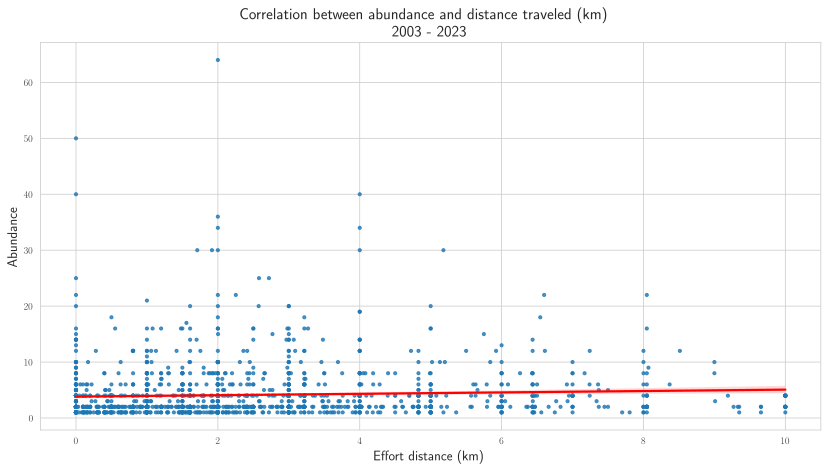

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Crear el gráfico de dispersión con línea de tendencia
plt.figure(figsize=(14, 7))
sns.regplot(data=filtered_data, x='effort_distance_km', y='observation_count', scatter_kws={'s':10}, line_kws={'color':'red'})

# Ajustar etiquetas y título
plt.xlabel('Effort distance (km)', fontsize=14)
plt.ylabel('Abundance', fontsize=14)
plt.title('Correlation between abundance and distance traveled (km) \n 2003 - 2023', weight='bold', fontsize=16)
plt.grid(True)

# Guardar el gráfico
plt.savefig('Correlation between abundance and distance traveled (km).png', format='png', bbox_inches='tight')
plt.savefig('Correlation between abundance and distance traveled (km).pdf', format='pdf', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

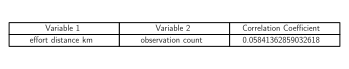

In [ ]:
# Calcular la correlación de Pearson
correlation = filtered_data['effort_distance_km'].corr(filtered_data['observation_count'])

# Crear la tabla con la correlación
correlation_table = pd.DataFrame({
    'Variable 1': ['effort_distance_km'],
    'Variable 2': ['observation_count'],
    'Correlation Coefficient': [correlation]
})

# Renderizar la tabla como imagen
fig, ax = plt.subplots(figsize=(6, 1))  # Tamaño de la imagen
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=correlation_table.values, colLabels=correlation_table.columns, cellLoc='center', loc='center')

# Guardar la tabla como imagen
plt.savefig('tabla_correlation_abundance_distance.png', format='png', bbox_inches='tight')
plt.savefig('tabla_correlation_abundance_distance.pdf', format='pdf', bbox_inches='tight')

# Mostrar la tabla
plt.show()

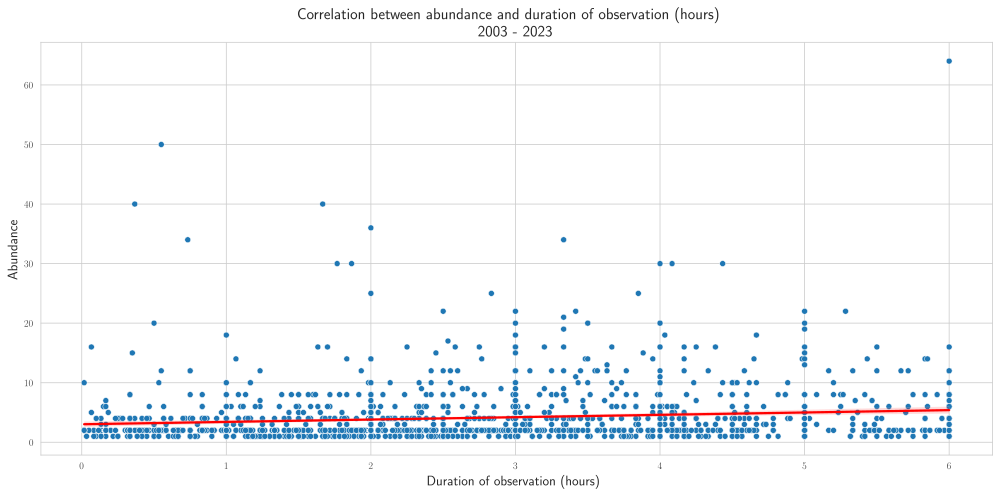

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Convertir la duración de minutos a horas
filtered_data['duration_hours'] = filtered_data['duration_minutes'] / 60

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(data=filtered_data, x='duration_hours', y='observation_count')

# Añadir una línea de tendencia
sns.regplot(data=filtered_data, x='duration_hours', y='observation_count', scatter=False, color='red')

# Ajustar etiquetas y título
plt.xlabel('Duration of observation (hours)', fontsize=14)
plt.ylabel('Abundance', fontsize=14)
plt.title('Correlation between abundance and duration of observation (hours) \n 2003 - 2023', weight='bold', fontsize=16)
plt.grid(True)

save_fig('Correlation between abundance and duration of observation', tight_layout=True, fig_extension="png", resolution=300)
save_fig('Correlation between abundance and duration of observation', tight_layout=True, fig_extension="pdf", resolution=300)

# Mostrar el gráfico
plt.show()

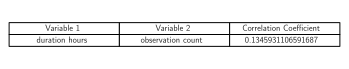

In [ ]:
# Calcular la correlación de Pearson
correlation2 = filtered_data['duration_hours'].corr(filtered_data['observation_count'])

# Crear la tabla con la correlación
correlation_table0 = pd.DataFrame({
    'Variable 1': ['duration_hours'],
    'Variable 2': ['observation_count'],
    'Correlation Coefficient': [correlation2]
})

# Renderizar la tabla como imagen
fig, ax = plt.subplots(figsize=(6, 1))  # Tamaño de la imagen
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=correlation_table0.values, colLabels=correlation_table0.columns, cellLoc='center', loc='center')

# Guardar la tabla como imagen
plt.savefig('tabla_correlation_abundance_horas.png', format='png', bbox_inches='tight')
plt.savefig('tabla_correlation_abundance_horas.pdf', format='pdf', bbox_inches='tight')

# Mostrar la tabla
plt.show()

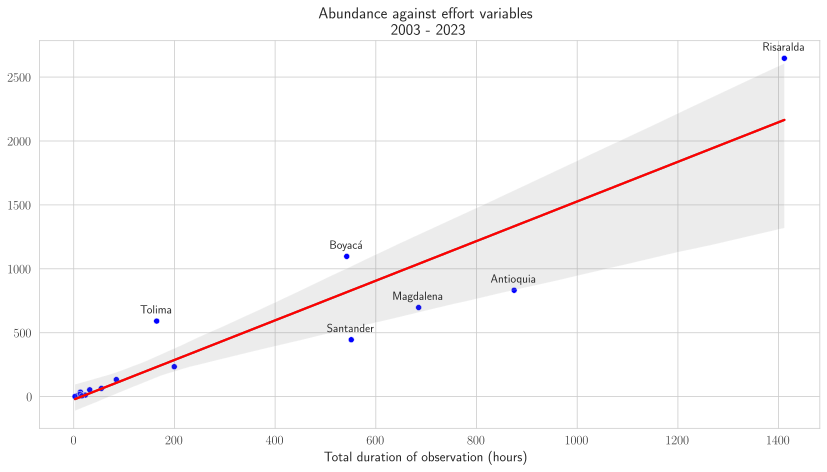

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Convertir la duración de minutos a horas
filtered_data['duration_hours'] = filtered_data['duration_minutes'] / 60

# Agrupar por departamento y calcular la suma de horas y observaciones
df_dept_summary = filtered_data.groupby('state').agg({'duration_hours': 'sum', 'observation_count': 'sum'}).reset_index()

# Calcular el coeficiente de correlación de Pearson
correlation_1 = df_dept_summary['duration_hours'].corr(df_dept_summary['observation_count'])

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(data=df_dept_summary, x='duration_hours', y='observation_count', color='blue')

# Añadir una línea de regresión gris con región de incertidumbre
sns.regplot(data=df_dept_summary, x='duration_hours', y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'grey'}, ci=95)

# Añadir una línea de regresión roja sin región de incertidumbre
sns.regplot(data=df_dept_summary, x='duration_hours', y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'red'}, ci=None)

# Añadir etiquetas de los departamentos sobre cada punto con mayor desplazamiento vertical
for i in range(df_dept_summary.shape[0]):
    if df_dept_summary['observation_count'][i] >= 250:
        plt.text(df_dept_summary['duration_hours'][i], df_dept_summary['observation_count'][i] + 60, df_dept_summary['state'][i], fontsize=12, ha='center')

# Ajustar etiquetas y título
plt.xlabel('Total duration of observation (hours)', fontsize=14, weight='bold')
plt.ylabel('', fontsize=14, weight='bold')
plt.title('Abundance against effort variables \n 2003 - 2023', weight='bold', fontsize=16)
plt.grid(True)

# Aumentar el tamaño de las marcas de los ejes
plt.tick_params(axis='both', which='major', labelsize=13)

# Guardar la imagen
plt.savefig('Abundance_by_department_and_total_duration_of_observation_hours.png', dpi=300, bbox_inches='tight')
plt.savefig('Abundance_by_department_and_total_duration_of_observation_hours.pdf', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

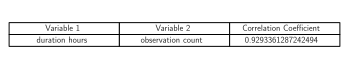

In [ ]:
# Crear la tabla con la correlación
correlation_table_1 = pd.DataFrame({
    'Variable 1': ['duration_hours'],
    'Variable 2': ['observation_count'],
    'Correlation Coefficient': [correlation_1]
})
# Renderizar la tabla como imagen
fig, ax = plt.subplots(figsize=(6, 1))  # Tamaño de la imagen
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=correlation_table_1.values, colLabels=correlation_table_1.columns, cellLoc='center', loc='center')

# Guardar la tabla como imagen
plt.savefig('tabla_correlation_Abundance by department and total duration of observation (hours).png', format='png', bbox_inches='tight')
plt.savefig('tabla_correlation_Abundance by department and total duration of observation (hours).pdf', format='pdf', bbox_inches='tight')

# Mostrar la tabla
plt.show()

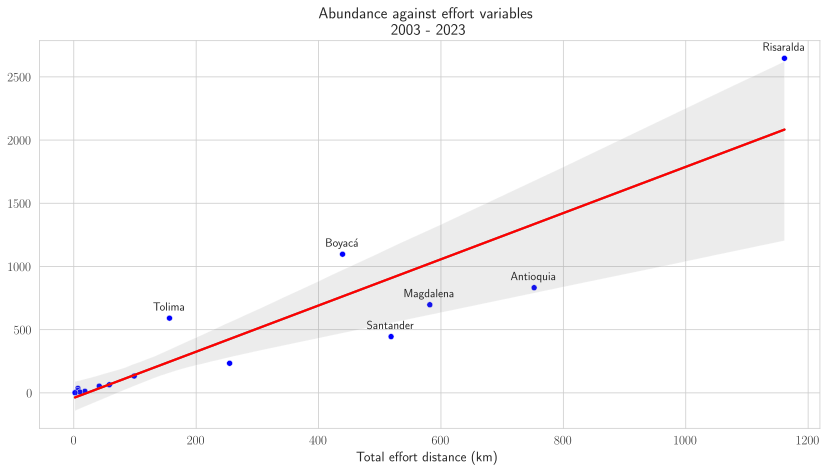

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Agrupar por departamento y calcular la suma de esfuerzo en kilómetros y observaciones
df_dept_summary = filtered_data.groupby('state').agg({'effort_distance_km': 'sum', 'observation_count': 'sum'}).reset_index()

# Calcular el coeficiente de correlación de Pearson
correlation_1 = df_dept_summary['effort_distance_km'].corr(df_dept_summary['observation_count'])

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(data=df_dept_summary, x='effort_distance_km', y='observation_count', color='blue')

# Añadir una línea de regresión gris con región de incertidumbre
sns.regplot(data=df_dept_summary, x='effort_distance_km', y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'grey'}, ci=95)

# Añadir una línea de regresión roja sin región de incertidumbre
sns.regplot(data=df_dept_summary, x='effort_distance_km', y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'red'}, ci=None)

# Añadir etiquetas de los departamentos sobre cada punto con mayor desplazamiento vertical
for i in range(df_dept_summary.shape[0]):
    if df_dept_summary['observation_count'][i] >= 250:
        plt.text(df_dept_summary['effort_distance_km'][i], df_dept_summary['observation_count'][i] + 60, df_dept_summary['state'][i], fontsize=12, ha='center')

# Ajustar etiquetas y título
plt.xlabel('Total effort distance (km)', fontsize=14, weight='bold')
plt.ylabel('', fontsize=14, weight='bold')
plt.title('Abundance against effort variables \n 2003 - 2023', weight='bold', fontsize=16)
plt.grid(True)

# Aumentar el tamaño de las marcas de los ejes
plt.tick_params(axis='both', which='major', labelsize=13)

# Guardar la imagen
plt.savefig('Abundance_by_department_and_total_effort_distance_km.png', dpi=300, bbox_inches='tight')
plt.savefig('Abundance_by_department_and_total_effort_distance_km.pdf', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

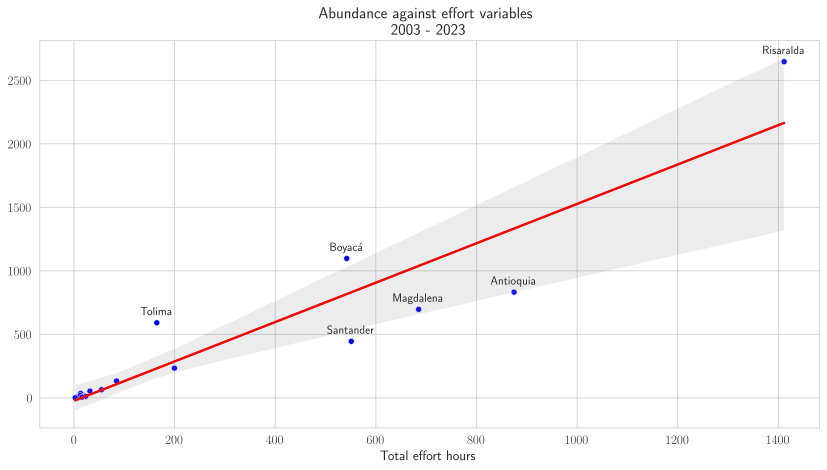

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Agrupar por departamento y calcular la suma de esfuerzo en kilómetros y observaciones
df_dept_summary = filtered_data.groupby('state').agg({'effort_hours': 'sum', 'observation_count': 'sum'}).reset_index()

# Calcular el coeficiente de correlación de Pearson
correlation_1 = df_dept_summary['effort_hours'].corr(df_dept_summary['observation_count'])

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(data=df_dept_summary, x='effort_hours', y='observation_count', color='blue')

# Añadir una línea de regresión gris con región de incertidumbre
sns.regplot(data=df_dept_summary, x='effort_hours', y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'grey'}, ci=95)

# Añadir una línea de regresión roja sin región de incertidumbre
sns.regplot(data=df_dept_summary, x='effort_hours', y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'red'}, ci=None)

# Añadir etiquetas de los departamentos sobre cada punto con mayor desplazamiento vertical
for i in range(df_dept_summary.shape[0]):
    if df_dept_summary['observation_count'][i] >= 250:
        plt.text(df_dept_summary['effort_hours'][i], df_dept_summary['observation_count'][i] + 60, df_dept_summary['state'][i], fontsize=12, ha='center')

# Ajustar etiquetas y título
plt.xlabel('Total effort hours', fontsize=14, weight='bold')
plt.ylabel('', fontsize=14, weight='bold')
plt.title('Abundance against effort variables \n 2003 - 2023', weight='bold', fontsize=16)
plt.grid(True)

# Aumentar el tamaño de las marcas de los ejes
plt.tick_params(axis='both', which='major', labelsize=13)

# Guardar la imagen
plt.savefig('Abundance_by_department_and_total_effort_hours.png', dpi=300, bbox_inches='tight')
plt.savefig('Abundance_by_department_and_total_effort_hours.pdf', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

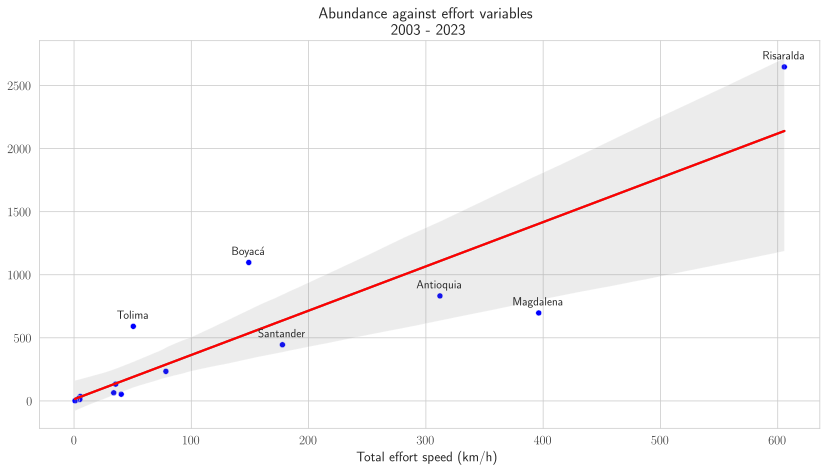

In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Agrupar por departamento y calcular la suma de esfuerzo en kilómetros y observaciones
df_dept_summary = filtered_data.groupby('state').agg({'effort_speed_kmph': 'sum', 'observation_count': 'sum'}).reset_index()

# Calcular el coeficiente de correlación de Pearson
correlation_1 = df_dept_summary['effort_speed_kmph'].corr(df_dept_summary['observation_count'])

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(data=df_dept_summary, x='effort_speed_kmph', y='observation_count', color='blue')

# Añadir una línea de regresión gris con región de incertidumbre
sns.regplot(data=df_dept_summary, x='effort_speed_kmph', y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'grey'}, ci=95)

# Añadir una línea de regresión roja sin región de incertidumbre
sns.regplot(data=df_dept_summary, x='effort_speed_kmph', y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'red'}, ci=None)

# Añadir etiquetas de los departamentos sobre cada punto con mayor desplazamiento vertical
for i in range(df_dept_summary.shape[0]):
    if df_dept_summary['observation_count'][i] >= 250:
        plt.text(df_dept_summary['effort_speed_kmph'][i], df_dept_summary['observation_count'][i] + 60, df_dept_summary['state'][i], fontsize=12, ha='center')

# Ajustar etiquetas y título
plt.xlabel('Total effort speed (km/h)', fontsize=14, weight='bold')
plt.ylabel('', fontsize=14, weight='bold')
plt.title('Abundance against effort variables \n 2003 - 2023', weight='bold', fontsize=16)
plt.grid(True)

# Aumentar el tamaño de las marcas de los ejes
plt.tick_params(axis='both', which='major', labelsize=13)

# Guardar la imagen
plt.savefig('Abundance_by_department_and_total_effort_speed_kmph.png', dpi=300, bbox_inches='tight')
plt.savefig('Abundance_by_department_and_total_effort_speed_kmph.pdf', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

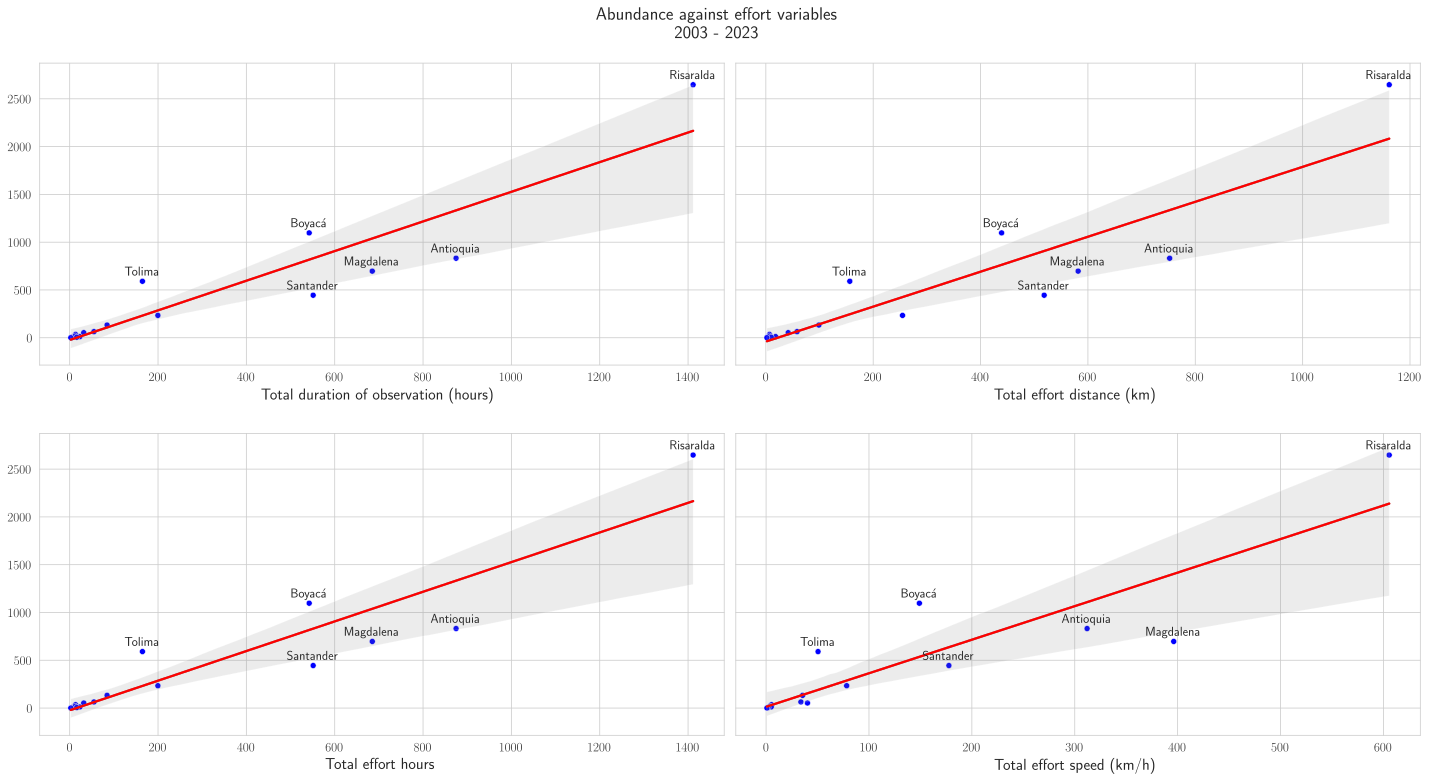

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Convertir la duración de minutos a horas
filtered_data['duration_hours'] = filtered_data['duration_minutes'] / 60

# Crear una figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=True)  # Cambiar tamaño a más ancho y un poco más alto

# Lista de pares (x, xlabel)
effort_metrics = [
    ('duration_hours', 'Total duration of observation (hours)'),
    ('effort_distance_km', 'Total effort distance (km)'),
    ('effort_hours', 'Total effort hours'),
    ('effort_speed_kmph', 'Total effort speed (km/h)')
]

# Generar los gráficos de dispersión
for idx, (metric, xlabel) in enumerate(effort_metrics):
    # Agrupar por departamento y calcular la suma del esfuerzo y observaciones
    df_dept_summary = filtered_data.groupby('state').agg({metric: 'sum', 'observation_count': 'sum'}).reset_index()

    # Calcular el coeficiente de correlación de Pearson
    correlation_1 = df_dept_summary[metric].corr(df_dept_summary['observation_count'])

    # Crear el gráfico de dispersión
    ax = axes[idx // 2, idx % 2]
    scatter_plot = sns.scatterplot(data=df_dept_summary, x=metric, y='observation_count', color='blue', ax=ax)

    # Añadir una línea de regresión gris con región de incertidumbre
    sns.regplot(data=df_dept_summary, x=metric, y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'grey'}, ci=95)

    # Añadir una línea de regresión roja sin región de incertidumbre
    sns.regplot(data=df_dept_summary, x=metric, y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'red'}, ci=None)

    # Añadir etiquetas de los departamentos sobre cada punto con mayor desplazamiento vertical
    for i in range(df_dept_summary.shape[0]):
        if df_dept_summary['observation_count'][i] >= 250:
            ax.text(df_dept_summary[metric][i], df_dept_summary['observation_count'][i] + 60, df_dept_summary['state'][i], fontsize=13, ha='center')

    # Ajustar etiquetas y título del subplot
    ax.set_xlabel(xlabel, fontsize=16, weight='bold')
    ax.set_ylabel('', fontsize=16, weight='bold')
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=13)

# Ajustar el título general
plt.suptitle('Abundance against effort variables \n 2003 - 2023', weight='bold', fontsize=18, y=0.90)

# Ajustar el espaciado para evitar superposición y agregar espacio entre las filas de gráficos
plt.tight_layout(rect=[0, 0, 1, 0.90], h_pad=3)

# Guardar la imagen
plt.savefig('Abundance_by_department_combined.png', dpi=300, bbox_inches='tight')
plt.savefig('Abundance_by_department_combined.pdf', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()


In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Convertir la duración de minutos a horas
filtered_data['duration_hours'] = filtered_data['duration_minutes'] / 60

# Agrupar por departamento y calcular la suma de las variables de interés
df_dept_summary = filtered_data.groupby('state').agg({
    'effort_speed_kmph': 'sum',
    'effort_hours': 'sum',
    'effort_distance_km': 'sum',
    'duration_hours': 'sum',
    'observation_count': 'sum'
}).reset_index()

# Seleccionar solo las columnas numéricas para la matriz de correlación
numeric_columns = df_dept_summary.select_dtypes(include='number')

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

# Crear un mapa de calor para la matriz de correlación
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='GnBu', linewidths=0.5, fmt=".2f")

# Ajustar las etiquetas de los ejes
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=13)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=13)

plt.title('Correlation matrix', fontsize=18, weight='bold')

# Guardar la imagen
plt.savefig('Correlation matrix', dpi=300, bbox_inches='tight')
plt.savefig('Correlation matrix', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Agrupar por departamento y contar el número de especies distintas
df_species_count = filtered_data.groupby('state')['scientific_name'].nunique().reset_index()
df_species_count = df_species_count.rename(columns={'scientific_name': 'unique_species_count'})

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))
sns.barplot(data=df_species_count, x='state', y='unique_species_count', color='skyblue')

# Ajustar etiquetas y título
plt.xlabel('Department', fontsize=16, weight='bold')
plt.ylabel('Richness', fontsize=16, weight='bold')
plt.title('Endemic bird richness by department \n 2003 - 2023', weight='bold', fontsize=16)
plt.xticks(rotation=90)

# Aumentar el tamaño de las marcas de los ejes
plt.tick_params(axis='both', which='major', labelsize=13)

save_fig('Endemic bird richness by department \n 2003 - 2023', tight_layout=True, fig_extension="png", resolution=300)
save_fig('Endemic bird richness by department \n 2003 - 2023', tight_layout=True, fig_extension="pdf", resolution=300)

# Mostrar el gráfico
plt.show()


In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Crear el gráfico de caja
plt.figure(figsize=(14, 7))
sns.boxplot(data=filtered_data, x='state', y='observation_count')

# Ajustar etiquetas y título
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Departament', fontsize=14)
plt.ylabel('Abundance', fontsize=14)
plt.title('Distribution of abundance by department \n 2003 - 2023', weight='bold', fontsize=16)
plt.grid(True)

save_fig('Distribution of abundance by department \n 2003 - 2023', tight_layout=True, fig_extension="png", resolution=300)
save_fig('Distribution of abundance by department \n 2003 - 2023', tight_layout=True, fig_extension="pdf", resolution=300)

# Mostrar el gráfico
plt.show()

# Descargar la imagen
# files.download('boxplot_observaciones_por_departamento.png')


In [ ]:
# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_cr[df_cr['observation_count'] > 0]

# Agrupar las horas del día en intervalos específicos
bins = [0, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24]
labels = ['0-5', '5-7', '7-9', '9-11', '11-13', '13-15', '15-17', '17-19', '19-21', '21-24']
filtered_data['hour_group'] = pd.cut(filtered_data['hours_of_day'], bins=bins, labels=labels, right=False)

# Agrupar por intervalos de horas y sumar el conteo de observaciones
df_hourly = filtered_data.groupby('hour_group').agg({'observation_count': 'sum'}).reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))
sns.barplot(data=df_hourly, x='hour_group', y='observation_count', color='#66c2a5')  # Usando un color pastel

# Ajustar etiquetas y título
plt.xlabel('Hour of the day (Grouped intervals)', fontsize=14)
plt.ylabel('Abundance', fontsize=14)
plt.title('Distribution of abundance by hour of the day \n 2003 - 2023', weight='bold', fontsize=16)
plt.grid(True)

save_fig('Distribution of abundance by hour of the day \n 2003 - 2023', tight_layout=True, fig_extension="png", resolution=300)
save_fig('Distribution of abundance by hour of the day \n 2003 - 2023', tight_layout=True, fig_extension="pdf", resolution=300)

# Mostrar el gráfico
plt.show()


In [27]:
import pandas as pd
import os

# Datos de la tabla
data = {
    "Peligro Crítico (CR)": [
        "Atlapetes blancae", "Chrysuronia lilliae", "Coeligena orina", "Crax alberti",
        "Eriocnemis isabellae", "Eriocnemis mirabilis", "Grallaria urraoensis", "Hapalopsittaca fuertesi",
        "Henicorhina negreti", "Lipaugus weberi", "Oxypogon cyanolaemus", "Thryophilus nicefori", "Troglodytes monticola"
    ],
    "En Peligro (EN)": [
        "Atlapetes flaviceps", "Bangsia aureocincta", "Campylopterus phainopeplus", "Cistothorus apolinari",
        "Diglossa gloriosissima", "Grallaria kaestneri", "Leptotila conoveri", "Macroagelaius subalaris",
        "Myiotheretes pernix", "Odontophorus strophium", "Penelope perspicax", "Phylloscartes lanyoni",
        "Psarocolius cassini", "Pyrrhura viridicata", "Rallus semiplumbeus", "Ramphomicron dorsale",
        "Saucerottia castaneiventris", "Scytalopus canus", "Scytalopus rodriguezi"
    ],
    "Vulnerable (VU)": [
        "Anthocephala berlepschi", "Anthocephala floriceps", "Bangsia melanochlamys", "Bolborhynchus ferrugineifrons",
        "Capito hypoleucus", "Chlorochrysa nitidissima", "Coeligena prunellei", "Dacnis hartlaubi",
        "Grallaria bangsi", "Grallaria milleri", "Hypopyrrhus pyrohypogaster", "Myiothlypis basilica",
        "Oxypogon stuebelii", "Pyrrhura calliptera", "Synallaxis fuscorufa", "Vireo caribaeus"
    ],
    "Casi Amenazada (NT)": [
        "Arremon basilicus", "Atlapetes fuscoolivaceus", "Bucco noanamae", "Clibanornis rufipectus",
        "Drymophila caudata", "Drymophila hellmayri", "Habia gutturalis", "Myiothlypis conspicillata",
        "Odontophorus hyperythrus"
    ],
    "Preocupación Menor (LC)": [
        "Anisognathus melanogenys", "Atlapetes melanocephalus", "Cercomacroides parkeri", "Chaetocercus astreans",
        "Chlorostilbon olivaresi", "Coeligena phalerata", "Cranioleuca hellmayri", "Euphonia concinna",
        "Habia cristata", "Henicorhina anachoreta", "Megascops gilesi", "Melanerpes pulcher", "Myiarchus apicalis",
        "Myioborus flavivertex", "Ortalis columbiana", "Ortalis garrula", "Oxypogon guerinii",
        "Picumnus granadensis", "Saucerottia cyanifrons", "Scytalopus alvarezlopezi", "Scytalopus latebricola",
        "Scytalopus sanctaemartae", "Scytalopus stilesi", "Synallaxis subpudica", "Vireo approximans"
    ]
}

# Crear DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))

In [28]:
# Aplicar el filtro
filtered_df_final = df_cr[(df_cr['scientific_name'] == 'Henicorhina negreti')]

# Mostrar el DataFrame filtrado
filtered_df_final

,checklist_id,last_edited_date,country,country_code,state,state_code,locality,locality_id,locality_type,latitude,...,trip_comments,scientific_name,observation_count,species_observed,status_co,effort_hours,effort_speed_kmph,hours_of_day,year,day_of_year
7,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.533333,0.750000,7.983333,2019.0,278.0
19,S61357410,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.650000,0.830769,7.483333,2019.0,315.0
31,S51579402,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.400000,0.000000,7.083333,2019.0,12.0
43,S59971734,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.750000,0.666667,7.700000,2019.0,264.0
55,S52070627,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.483333,0.641379,17.016667,2019.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4852471,G7635775,2022-10-25 02:01:53.77827,Colombia,CO,Boyacá,CO-BOY,"Bosque, Sendero salto Candelas, vda. Corinto, ...",L13525414,P,5.422280,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.883333,1.494340,9.033333,2022.0,2.0
4852483,G7636828,2022-02-17 18:09:32.218588,Colombia,CO,La Guajira,CO-LAG,SFF Los Flamencos - Ciénaga del Navío Quebrado,L843776,H,11.418022,...,Boat trip from Boca down to about 5km south on...,Henicorhina negreti,0,False,En peligro critico,2.533333,2.368421,15.166667,2022.0,2.0
4852495,G7637309,2022-10-26 05:29:12.817965,Colombia,CO,Risaralda,CO-RIS,Alto de La Linea,L3010133,H,5.169848,...,NaN,Henicorhina negreti,0,False,En peligro critico,2.466667,0.454054,14.650000,2022.0,2.0
4852507,G7637526,2022-01-02 18:52:37.153398,Colombia,CO,Meta,CO-MET,Villa Paulina,L15473218,P,4.152331,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.166667,0.000000,18.350000,2022.0,2.0


In [31]:
# Aplicar el filtro
filtered_df_final2_CR = filtered_df_final[(filtered_df_final['state'] == 'Risaralda')]

# Mostrar el DataFrame filtrado
filtered_df_final2_CR

,checklist_id,last_edited_date,country,country_code,state,state_code,locality,locality_id,locality_type,latitude,...,trip_comments,scientific_name,observation_count,species_observed,status_co,effort_hours,effort_speed_kmph,hours_of_day,year,day_of_year
139,S52977144,2023-10-24 07:14:28.845856,Colombia,CO,Risaralda,CO-RIS,Via La Florida -- La Suiza,L6672775,P,4.744578,...,NaN,Henicorhina negreti,0,False,En peligro critico,1.266667,3.434211,6.783333,2019.0,51.0
151,S54895798,2023-10-24 07:21:35.964443,Colombia,CO,Risaralda,CO-RIS,Via La Florida -- La Suiza,L6672775,P,4.744578,...,NaN,Henicorhina negreti,0,False,En peligro critico,1.000000,0.000000,11.000000,2019.0,101.0
163,S61672676,2023-10-24 07:51:59.264845,Colombia,CO,Risaralda,CO-RIS,Via La Florida -- La Suiza,L6672775,P,4.744578,...,NaN,Henicorhina negreti,0,False,En peligro critico,1.266667,1.602632,5.783333,2019.0,327.0
1375,S52411371,2019-02-05 14:34:52,Colombia,CO,Risaralda,CO-RIS,Av 30 de Agosto Calle 39,L6720653,P,4.813223,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.416667,1.920000,7.583333,2019.0,35.0
1387,S55205250,2021-08-19 17:25:20.91149,Colombia,CO,Risaralda,CO-RIS,Casa La Lolita Vereda Tribuna- Consota,L6729274,P,4.772187,...,NaN,Henicorhina negreti,0,False,En peligro critico,5.000000,0.000000,12.833333,2019.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4851991,G7618167,2023-10-23 19:05:10.524796,Colombia,CO,Risaralda,CO-RIS,RN Cauquitá,L5797600,H,4.843038,...,NaN,Henicorhina negreti,0,False,En peligro critico,2.083333,0.000000,16.116667,2021.0,362.0
4852039,G7629007,2023-10-24 04:02:22.868324,Colombia,CO,Risaralda,CO-RIS,"Vía Florida - el Cedral, Filandia CO-Quindío 4...",L17260826,P,4.746485,...,NaN,Henicorhina negreti,0,False,En peligro critico,1.000000,0.000000,6.616667,2022.0,1.0
4852303,G7627463,2022-01-01 19:40:45.006052,Colombia,CO,Risaralda,CO-RIS,Sendero La Linea,L7465754,H,5.180619,...,NaN,Henicorhina negreti,0,False,En peligro critico,2.450000,0.640816,14.950000,2022.0,1.0
4852315,G7629957,2022-01-02 00:31:41.538246,Colombia,CO,Risaralda,CO-RIS,Apia (pueblo),L2292807,H,5.105204,...,NaN,Henicorhina negreti,0,False,En peligro critico,0.050000,0.000000,0.466667,2022.0,2.0


In [32]:
# Guardar el DataFrame filtrado en un archivo CSV
filtered_df_final2_CR.to_csv('filtered_df_final2_CR.csv', index=False)

# Descargar el archivo en Google Colab
from google.colab import files
files.download('filtered_df_final2_CR.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# Guardar el DataFrame filtrado en un archivo CSV en la ruta deseada
filtered_df_final2_CR.to_csv('/content/drive/MyDrive/Proyecto aplicado /Procesamiento objetivo 1/filtered_df_final2_CR.csv', index=False)

# Descargar el archivo en Google Colab
from google.colab import files
files.download('/content/drive/MyDrive/Proyecto aplicado /Procesamiento objetivo 1/filtered_df_final2_CR.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>